# Python course project - Intelligent places

# Task solving

### Preparation

Let's load the test input data into two arrays: images with the answer "yes" and images with the answer "no".

In [1]:
import cv2 as cv
import os

no_path = "data/no"
yes_path = "data/yes"

def read_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

no_data = read_images(no_path) # 9 images
yes_data = read_images(yes_path) # 7 images

To demonstrate the work process of the program, let's set any test image.

In [2]:
test_image = no_data[0]

### Finding objects borders

We use a Canny filter with a Gaussian kernel. We will also use the original image on the next step of the algorithm.

In [3]:
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

def get_canny(img):
    a_gray = rgb2gray(img)
    a_blur = gaussian(a_gray, 1)
    a_edges = canny(a_blur, sigma=0.1, low_threshold=0.1)
    return a_edges

### Recognition and identification of found objects

At this point, we need to find objects in the image. We know for sure that they exist (this is a requirement for input data), and now we need to determine correctly the location of the pelvis and table.
1. Let's find a table first. To do this, we apply the Hough transform to find lines in the image. We are interested in the table top - it is one or more straight lines, since the table top has a characteristic structure.

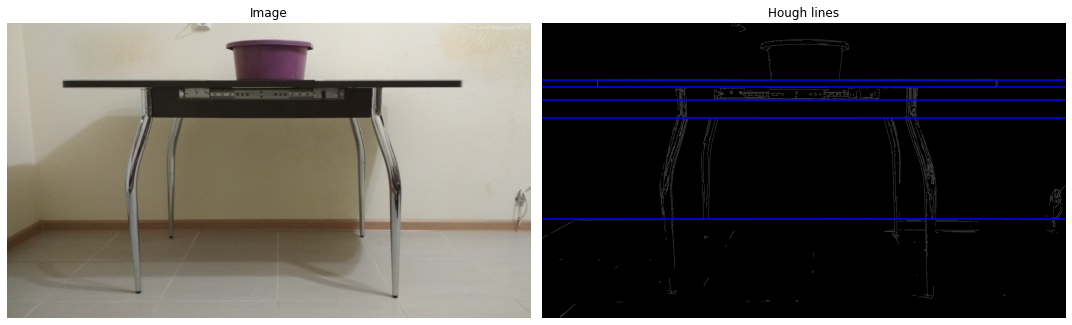

In [4]:
from skimage.transform import hough_line, hough_line_peaks
import numpy as np
from matplotlib import cm

def get_hough_transform(img):
    canny_img = get_canny(img)
    h, theta, d = hough_line(canny_img)
    line_peaks = hough_line_peaks(h, theta, d)
    lines = []
    
    x0 = 0
    x1 = img.shape[1]
    
    for h, angle, dist in zip(*line_peaks):
        y0 = dist / np.sin(angle)
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        lines.append((angle, dist, (x0, y0), (x1, y1)))
    
    # sorting by location by height inside the image
    lines = sorted(lines, key=lambda x: abs(x[1]), reverse=True)
    return lines

def show_hough(image, lines):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    ax[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    ax[0].set_title('Image')
    ax[0].set_axis_off()
    

    ax[1].imshow(get_canny(image), cmap=cm.gray)
    for _, _, p0, p1 in lines:
        ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]), '-b')
    ax[1].set_xlim((0, image.shape[1]))
    ax[1].set_ylim((image.shape[0], 0))
    ax[1].set_axis_off()
    ax[1].set_title('Hough lines')

    plt.tight_layout()

line_peaks = get_hough_transform(test_image)
show_hough(test_image, line_peaks)

Now the lines found must be filtered. Since there is a pronounced plinth and straight tiles in the background, we will delete single lines that are too far below the set of other found lines, since the plinth and tiles can be either at the bottom of the table or mixed with the lines on the table top (in this case, we won't filter). We will also remove straight lines that have too small angle of inclination. We assume that the set of straight lines of the table top does not have sharp intersections (since strong perspective distortion is prohibited).

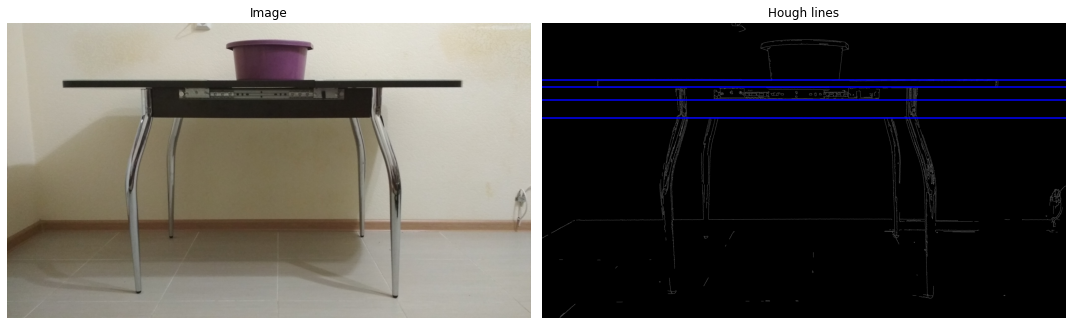

In [5]:
from shapely.geometry import LineString # installed using conda

ALLOWED_ANGLE = 1
ALLOWED_DISTANCE = 400
ALLOWED_TURN = 0.2

# proximity of lines

def find_outlier(elem, array):
    flag = 0
    for a in array:
        if abs(abs(int(a[1])) - abs(int(elem[1]))) > ALLOWED_DISTANCE:
            flag += 1
    # subtract 1 due to the fact that elem is also in array
    if flag == len(array)-1:
        # if the line is also the lowest, we consider it a piece of the floor
        if elem == array[0]:
            return False
    return True


# sharp intersection of lines 
# on the proposed dataset the function is not needed

def find_intersection(elem, array, img):
    height, width = img.shape[:2]
    for a in array:
        if abs(abs(int(elem[0])) - abs(int(a[0]))) > ALLOWED_TURN:
            # check if intersection lies inside the image
            line1 = LineString([a[2], a[3]])
            line2 = LineString([elem[2], elem[3]])
            inter = line1.intersection(line2)
            if (0 < inter.x < width) or (0 < inter.y < height):
                if abs(a[0]) > abs(elem[0]):
                    return elem
                else:
                    return a
    return None
                

def remove_noise(line_peaks, img):   
    new_lines = line_peaks.copy()
    
    # deleting lines by the angle of rotation
    for line in line_peaks:
        if abs(line[0]) <= ALLOWED_ANGLE:
            new_lines.remove(line)
    
    lines_copy = new_lines.copy()
    
    # remove straight plinth/tile lines
    for line in line_peaks:
        if line in new_lines:
            if not find_outlier(line, lines_copy):
                new_lines.remove(line)

    # remove the remaining intersecting lines
    for line in line_peaks:
        if line in new_lines:
            inter = find_intersection(line, new_lines, img)
            if inter and inter in new_lines:
                new_lines.remove(inter)
    
    return new_lines

new_lines = remove_noise(line_peaks, test_image)
show_hough(test_image, new_lines)

So, the lines defining the table have been found.

In [6]:
if not new_lines:
    print("Unfortunately, the table was not found. Please, try another image")
else:
    # set the table as the lowest of the remaining lines
    table = new_lines[0]

2. Now we have to find the pelvis. It is known that it is lilac, so we will try to find it by binarization by shades of lilac.

<ipython-input-7-08c9c8d0f6a4>:1: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_closing, binary_opening, binary_fill_holes
<ipython-input-7-08c9c8d0f6a4>:1: DeprecationWarning: Please use `binary_opening` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_closing, binary_opening, binary_fill_holes
<ipython-input-7-08c9c8d0f6a4>:1: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_closing, binary_opening, binary_fill_holes


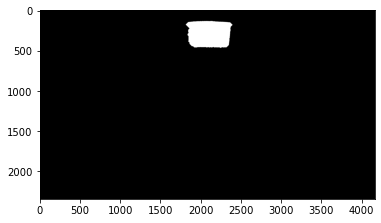

In [7]:
from scipy.ndimage.morphology import binary_closing, binary_opening, binary_fill_holes
from skimage.measure import label, regionprops

LILAC_MIN = np.array([60, 50, 41],np.uint8)
LILAC_MAX = np.array([179, 255, 255],np.uint8)

# finding the largest contour

def get_mask(img):
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    color_range = cv.inRange(hsv_img, LILAC_MIN, LILAC_MAX)
    
    mask = binary_closing(color_range, iterations = 3)
    img_segment = binary_fill_holes(mask)
    mask_img = binary_opening(img_segment, iterations = 30)
    
    # take the largest and remove another ones
    
    int_mask = label(mask_img)
    regions = regionprops(int_mask)
    regions = sorted(regions, key=lambda x: x.area, reverse=True)
    
    if len(regions) > 1:
        for r in regions[1:]:
            int_mask[r.coords[:,0], r.coords[:,1]] = 0
    
    int_mask[int_mask!=0] = 1
    
    return int_mask


mask = get_mask(test_image)
if any(1 in i for i in mask):
    plt.imshow(mask, cmap = cm.gray)
else:
    print("Unfortunately, the pelvis was not found. Please, try another image")

Pelvis mask is found. Now we need to determine the coordinates of its upper and lower parts, as well as find the bounding box of the pelvis.

In [8]:
def get_bowl_properties(mask):
    contours, _ = cv.findContours(mask, 1, 2)
    cnt = contours[0]
    # bounding box
    rect = cv.minAreaRect(cnt)
    # upper and lower extreme points
    max_p = tuple(cnt[cnt[:,:,1].argmin()][0])
    min_p = tuple(cnt[cnt[:,:,1].argmax()][0])
    
    return max_p, min_p, rect

new_mask = mask.astype(np.uint8)
bowl = get_bowl_properties(new_mask)

### Determining the relative position of objects. Answering to the main question

There is a pelvis defined by extreme coordinates and a bounding box, and a table defined by the bottom straight line of the tabletop (by two points of this straight line).

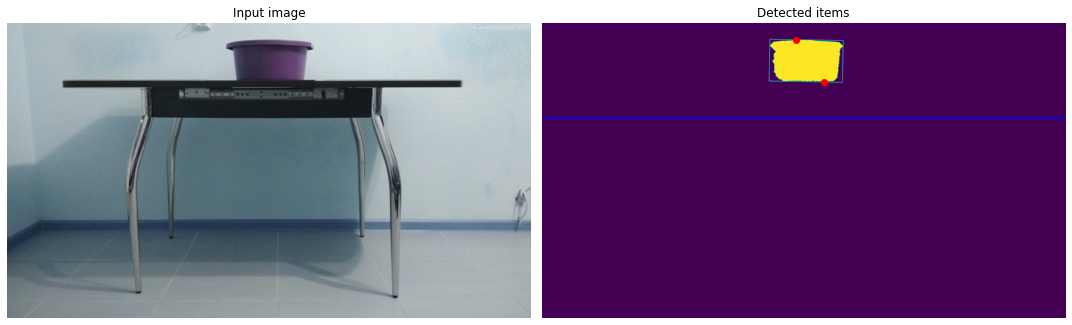

In [9]:
box = np.int0(cv.boxPoints(bowl[2]))
cv.drawContours(new_mask, [box], 0, (1, 0, 0), 2)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].imshow(test_image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(new_mask)
ax[1].plot(bowl[0][0], bowl[0][1], 'ro')
ax[1].plot(bowl[1][0], bowl[1][1], 'ro')
ax[1].set_xlim((0, test_image.shape[1]))
ax[1].set_ylim((test_image.shape[0], 0))

_, _, p0, p1 = table
ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]), '-b')
ax[1].set_axis_off()
ax[1].set_title('Detected items')

plt.tight_layout()

If the pelvis is completely below the straight line, we consider that the answer to the question is positive.  
If the pelvis is completely above the straight line - negative.  
If the pelvis intersects with a straight line, it is necessary to calculate what part of the pelvis is above it. If more than 75% - the answer is negative (thus we hope that the recognized straight line is still not a plinth). Otherwise - positive.  

In [10]:
from shapely.geometry import Polygon
from scipy.spatial import distance as dist

ALLOWED_PERCENTAGE = 0.75

def side_of_line(p1, p2, point):
    x, y = point
    x1, y1 = p1
    x2, y2 = p2
    return (x-x1)*(y2-y1) - (y-y1)*(x2-x1)

def line_crossing(box, p1, p2):
    line = LineString([p1, p2])
    intersect = Polygon(box).intersection(line)
    
    if intersect:
        return intersect.coords[:]
    else:
        return None
    

def trapezoid_area(rect, p1, p2):
    # find the coordinates of the intersection of the line with the bounding box
    box = np.int0(cv.boxPoints(rect))
    box_tuples = [tuple(elem) for elem in box]
    l1, l2 = line_crossing(box_tuples, p1, p2)
    
    # set the coordinates of the line anti-clockwise
    # because box_tuples is also anti-clockwise 
    polygon = [l2, l1]
    
    # find the coordinates of the polygon cut off by a line
    for p in box_tuples:
        if side_of_line(l1, l2, p) > 0:
            polygon.append(p)

    # find the area of a polygon
    poly = Polygon(polygon)
    return poly.area


def get_answer(table, bowl):
    angle, dist, p1, p2 = table
    max_p, min_p, rect = bowl
    
    if side_of_line(p1, p2, min_p) >= 0:
        return False
    elif side_of_line(p1, p2, max_p) <= 0:
        return True
    else:
        # on the proposed dataset the function is not needed
        center, wh, angle = rect
        w, h = wh
        area = w*h
        trapezoid = trapezoid_area(rect, p1, p2)
        if area*ALLOWED_PERCENTAGE <= trapezoid:
            return False
        else:
            return True

def print_answer(answer):
    if answer:
        print("Pelvis can be placed under the table")
    else:
        print("Pelvis cannot be placed under the table")

answer = get_answer(table, bowl)
print_answer(answer)

Pelvis cannot be placed under the table


Let's check both ot the datasets.

In [11]:
def check_data(data):
    for d in data:
        peaks = get_hough_transform(d)
        table_lines = remove_noise(peaks, d)
        tbl = table_lines[0]
        
        bowl_mask = get_mask(d)
        clean_mask = bowl_mask.astype(np.uint8)
        bwl = get_bowl_properties(clean_mask)
        ans = get_answer(tbl, bwl)
        print_answer(ans)

print("Checking dataset with 'no' answer:")
check_data(no_data)
print("\nChecking dataset with 'yes' answer:")
check_data(yes_data)

Checking dataset with 'no' answer:
Pelvis cannot be placed under the table
Pelvis cannot be placed under the table
Pelvis cannot be placed under the table
Pelvis cannot be placed under the table
Pelvis cannot be placed under the table
Pelvis cannot be placed under the table
Pelvis cannot be placed under the table
Pelvis cannot be placed under the table
Pelvis cannot be placed under the table

Checking dataset with 'yes' answer:
Pelvis can be placed under the table
Pelvis can be placed under the table
Pelvis can be placed under the table
Pelvis can be placed under the table
Pelvis can be placed under the table
Pelvis can be placed under the table
Pelvis can be placed under the table


__Nice! You are gorgeous!__